Rishabh Bhattacharya CSE276C HW4

# Problem 1

We will be analysing the following cases,

1. **PCA (50 components) -> LDA (25 components):** Base case for analysis, testing PCA and LDA, and discussing their differences
2. **PCA (50 components):** Test case to observe the effect of only PCA, without LDA
3. **PCA (25 components):** Test case to observe the effect of only PCA (with reduced dimensions), without LDA

We perform LDA after PCA in order to tacke the singularity problem in LDA which arises due to the no. of pixels in an image > training examples.

We will be following these steps,

1. **Resize images:** We need to resize all the images/features to be of the same size for PCA to work properly. We will resize according to the average height/weight of the ROI for all training data.
2. **Create features as flattened vectors:** The RGB images will be flattened to a 1D vector (each of size HxWx3), thus getting a (39209, HxWx3) matrix, where each row is a training image with HxWx3 features.
3. **Scale features:** The training data will be scaled to ensure proper functioning of the PCA.
4. **PCA of features:** At this point, we will implement PCA on our data to reduce the number of features (from HxWx3 to n_components).
5. **Test with training data (using SVC):** We test the explained variance and accuracy of the reduced features on the given test dataset by training a classifier on the reduced PCA data. We also plot the eigen images to obtain a visualization of the features as they have been created.
6. **Compare with LDA:** We compare our results of the PCA data with LDA data by training classifiers with both, and reflect on the results.

In [1]:
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import cv2


def normalize(img):
    """
    Normalized image for plt.imshow()
    """
    assert img.shape[2] == 3
    maxi = img.max()
    mini = img.min()
    return (img - mini)/(maxi-mini)

def image2feature(img, H, W):
    """
    Return 1D feature vector from 3 channel RGB image after resizing (feature length = H * W * 3).
    """
    new_image = cv2.resize(img, (W,H), interpolation = cv2.INTER_AREA)
    return np.ndarray.flatten(new_image)

def classify(train_X, train_y, test_X, test_y):
    """
    Run SVC and assess accuracy of classifier.
    """
    classifier = SVC(kernel='linear')
    classifier.fit(train_X, train_y)


    # Assess model accuracy
    # train_score  = classifier.score(train_X, train_y)
    test_score = classifier.score(test_X, test_y)
    # print("Correct | Incorrect classification on training data = %0.2f%%, %0.2f%%" %(train_score*100, (1-train_score)*100))
    print("Correct | Incorrect classification on testing data = %0.2f%%, %0.2f%%" %(test_score*100, (1-test_score)*100))

In [2]:
# Load data
test_data = pd.read_csv('dataset/Test.csv')
train_data = pd.read_csv('dataset/Train.csv')

In [3]:
# Calculate average image dimensions to resize training images
H_avg, W_avg = int((train_data["Roi.Y2"] - train_data["Roi.Y1"]).mean()), int((train_data["Roi.X2"] - train_data["Roi.X1"]).mean())
print('Average height and width of training images (in pixels): H = %d, W = %d' %(H_avg, W_avg))

Average height and width of training images (in pixels): H = 38, W = 39


Thus we will be using 38x39 as the standard size and resizing all the images accordingly. This is done so that later we have same length features from each training image. Each image will be flattened into a 1D array of length 4446 (38x39x3).

In [4]:
# Append 1D features to the train & test dataframe
train_data["Features"] = None
for idx in train_data.index:
    image = cv2.imread("dataset/" + train_data["Path"][idx])
    x1_roi, x2_roi, y1_roi, y2_roi = train_data["Roi.X1"][idx],train_data["Roi.X2"][idx],train_data["Roi.Y1"][idx],train_data["Roi.Y2"][idx]
    train_data["Features"][idx] = image2feature(image[y1_roi:y2_roi, x1_roi:x2_roi], H_avg, W_avg)

test_data["Features"] = None
for idx in test_data.index:
    image = cv2.imread("dataset/" + test_data["Path"][idx])
    x1_roi, x2_roi, y1_roi, y2_roi = test_data["Roi.X1"][idx],test_data["Roi.X2"][idx],test_data["Roi.Y1"][idx],test_data["Roi.Y2"][idx]
    test_data["Features"][idx] = image2feature(image[y1_roi:y2_roi, x1_roi:x2_roi], H_avg, W_avg)

/var/folders/91/p780b94d76v38rb7pry26_k00000gn/T/ipykernel_37196/141637384.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["Features"][idx] = image2feature(image[y1_roi:y2_roi, x1_roi:x2_roi], H_avg, W_avg)
/var/folders/91/p780b94d76v38rb7pry26_k00000gn/T/ipykernel_37196/141637384.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["Features"][idx] = image2feature(image[y1_roi:y2_roi, x1_roi:x2_roi], H_avg, W_avg)


## PCA (50 components) -> LDA (25 components)

In [5]:
# Create required matrices for PCA and classification later

X_train = np.array(train_data["Features"].values.tolist())
y_train = np.array(train_data["ClassId"].values.tolist())
X_test = np.array(test_data["Features"].values.tolist())
y_test = np.array(test_data["ClassId"].values.tolist())

### Scale features

In [6]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Implement PCA

In [7]:
n_components_pca = 50
pca = PCA(n_components=n_components_pca)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("PCA applied training data shape: ", X_train_pca.shape)
print("Variance explained by %d components = %0.1f%%" %(n_components_pca, sum(pca.explained_variance_ratio_*100)))
print("Variance explained by #1 component = %0.1f%%" %(pca.explained_variance_ratio_[0] * 100))
print("Variance explained by #1 + #2 components = %0.1f%%" %sum(pca.explained_variance_ratio_[:2]*100))

PCA applied training data shape:  (39209, 50)
Variance explained by 50 components = 92.5%
Variance explained by #1 component = 53.0%
Variance explained by #1 + #2 components = 64.4%


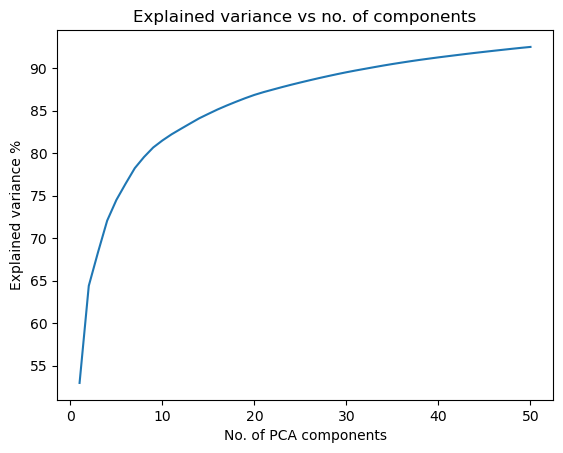

In [8]:
plt.plot(np.arange(1, n_components_pca+1), np.cumsum(pca.explained_variance_ratio_*100))
plt.xlabel('No. of PCA components')
plt.ylabel('Explained variance %')
plt.title('Explained variance vs no. of components')
plt.show()

We see that 50 components explain 92% of the variance in the data (originally 4446 components). Thus we can use n_components = 50 for PCA as a reasonable choice.

### Plot eigenvectors/eigenfaces of PCA

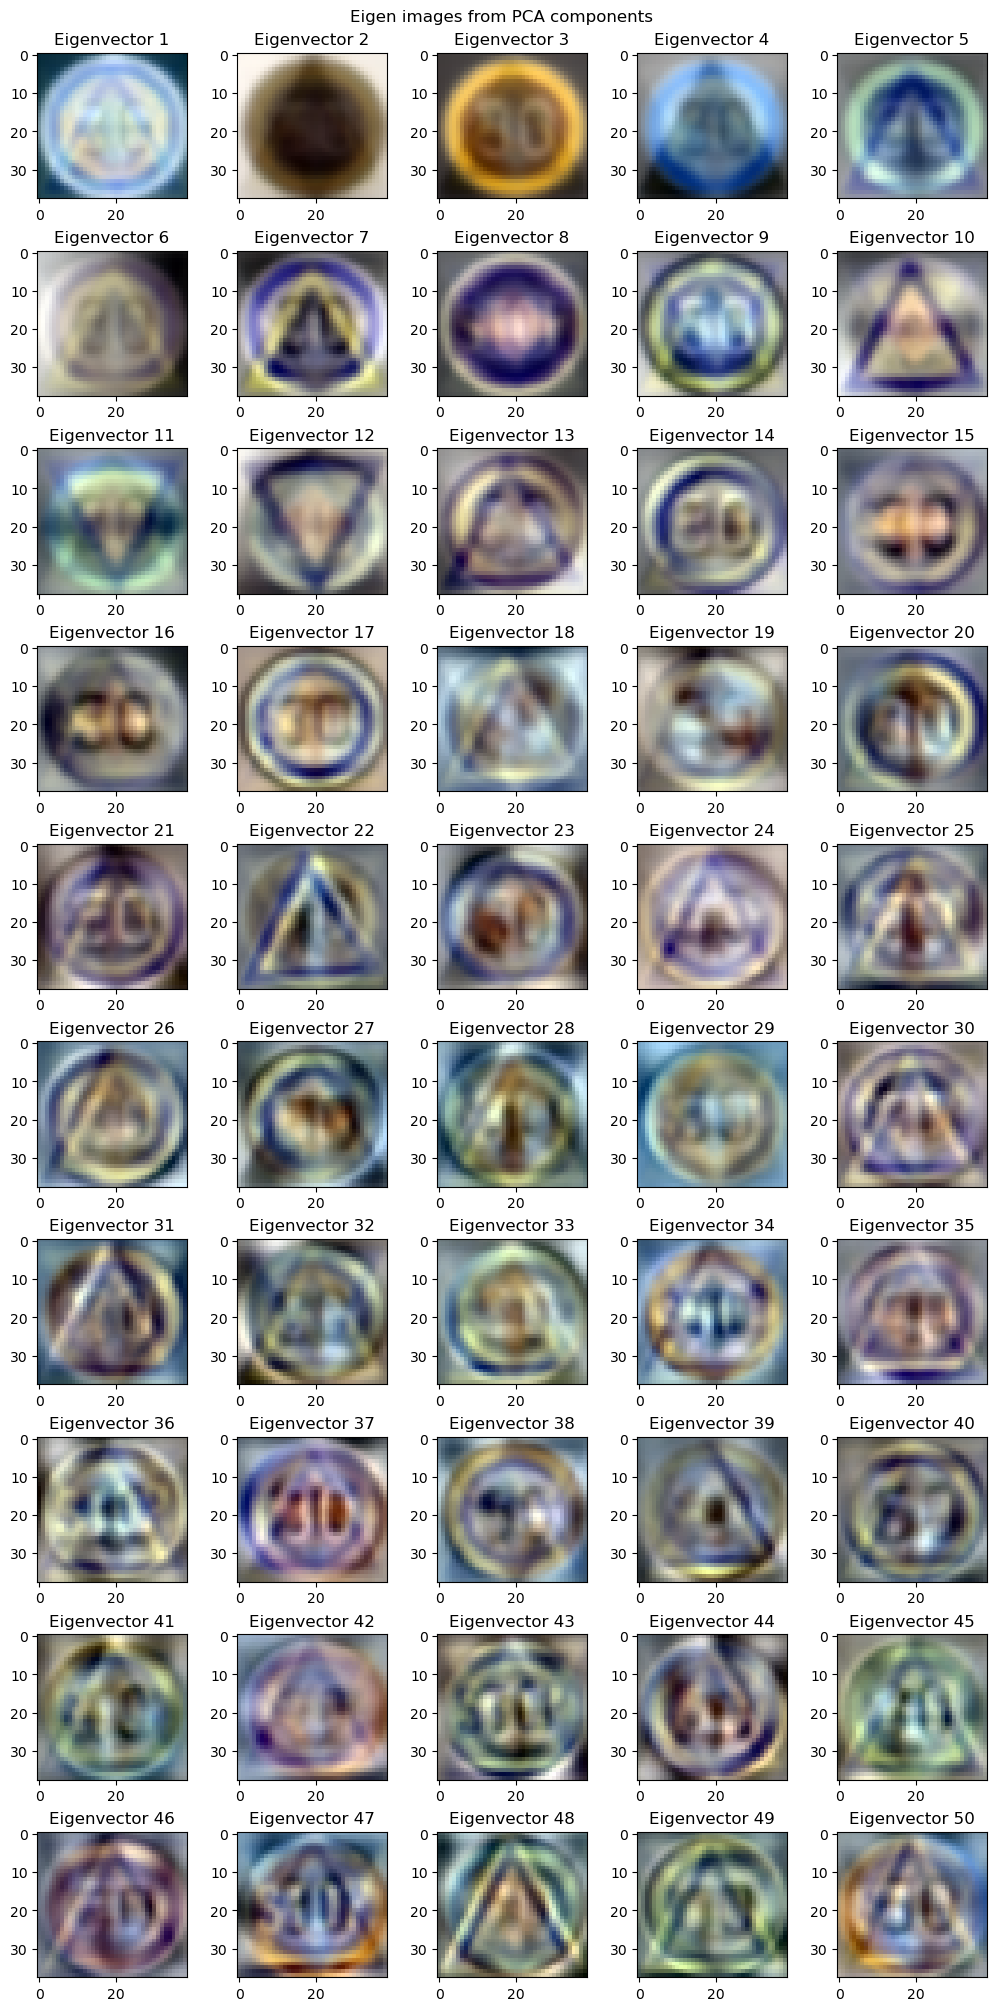

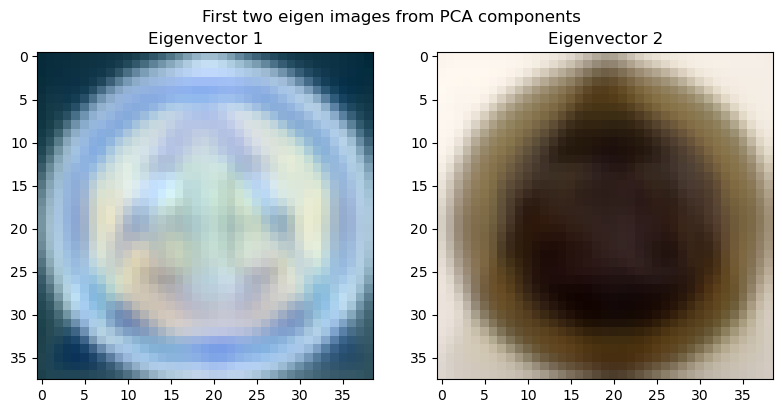

In [9]:
n_cols = 5             
n_rows = int(np.ceil(n_components_pca/n_cols))

fig, ax = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(10,20))
fig.suptitle('Eigen images from PCA components')
image_count=0
for i in range(n_rows):
    for j in range(n_cols):

        ax[i, j].imshow(normalize(pca.components_[image_count].reshape(H_avg, W_avg, 3)))
        ax[i,j].set_title('Eigenvector %d' %(image_count+1))
        image_count+=1

fig2, ax = plt.subplots(1, 2, layout='constrained', figsize=(8,4))
fig2.suptitle('First two eigen images from PCA components')
for i in range(2):
    ax[i].imshow(normalize(pca.components_[i].reshape(H_avg, W_avg, 3)))
    ax[i].set_title('Eigenvector %d' %(i+1))

### Classification performance on PCA data

Correct | Incorrect classification on testing data = 84.22%, 15.78%


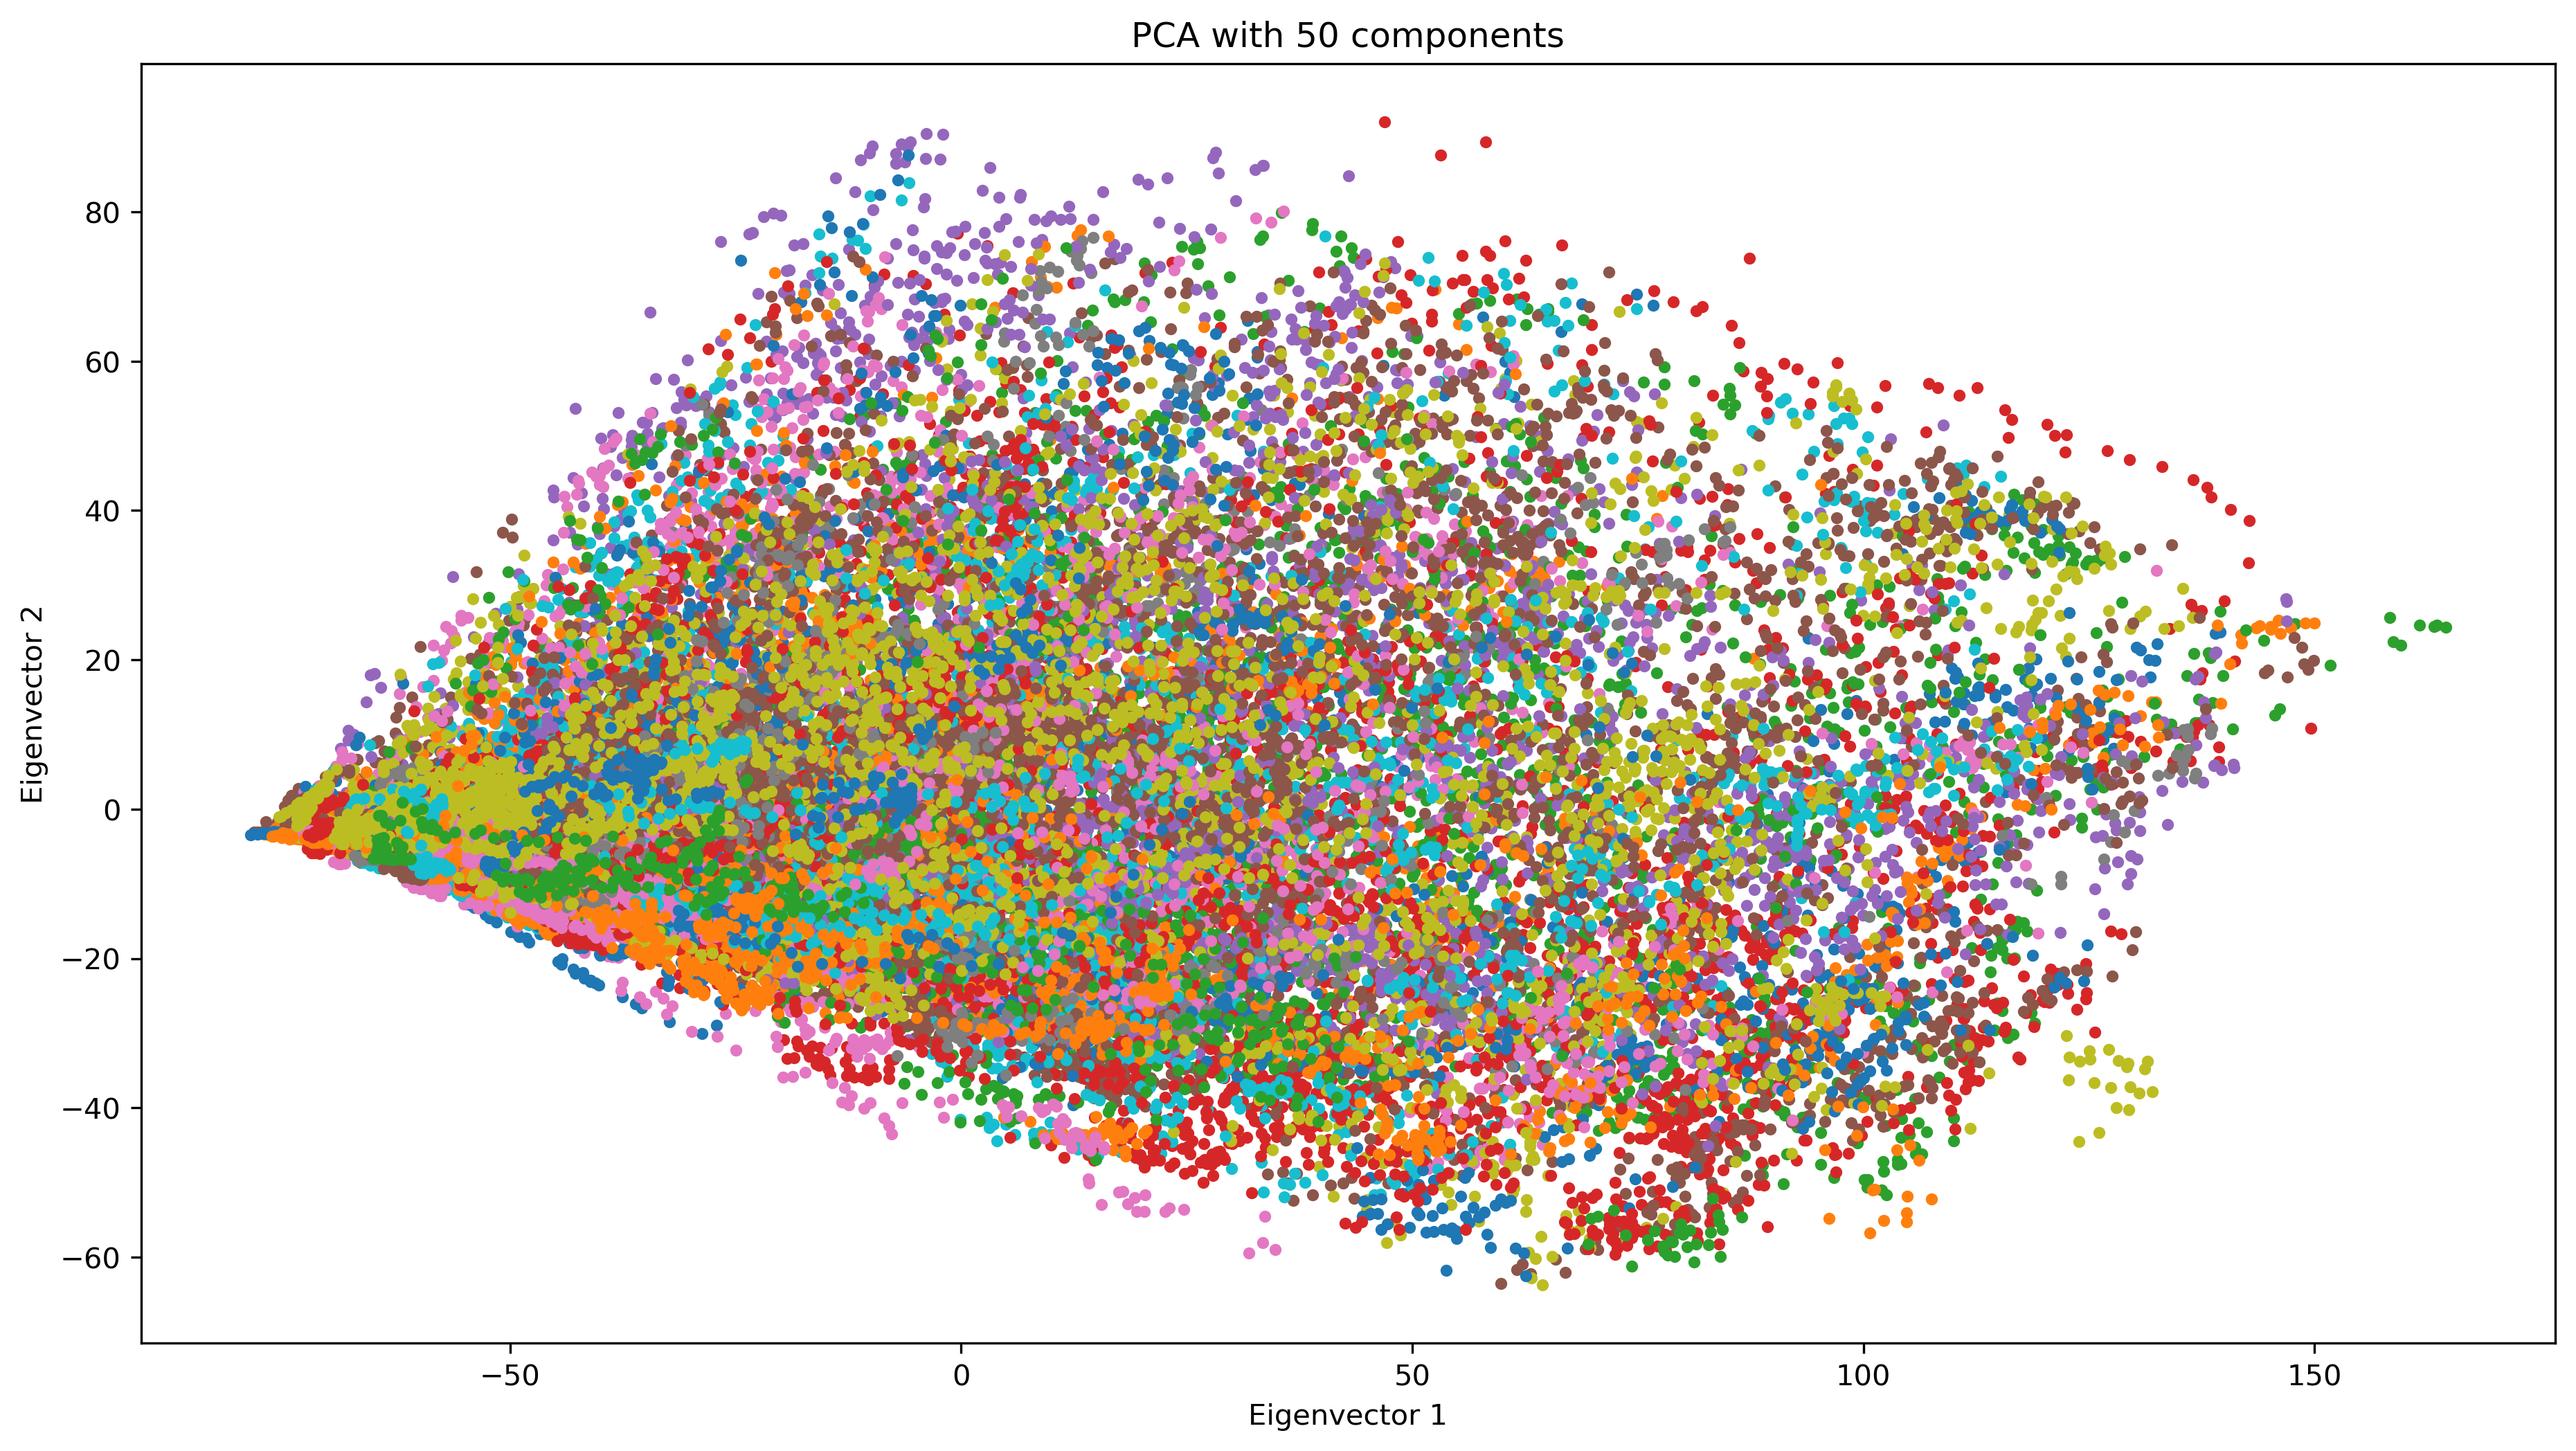

In [10]:
classify(X_train_pca, y_train, X_test_pca, y_test)      # Run classifier

plt.figure(figsize=(15,8), dpi=300)
for classid in train_data["ClassId"].unique():
    idx = np.where(train_data["ClassId"] == classid)
    plt.scatter(X_train_pca[idx,0], X_train_pca[idx,1], s=10)

plt.title('PCA with %d components' %n_components_pca)
plt.xlabel('Eigenvector 1')
plt.ylabel('Eigenvector 2')
plt.show()

We observe that the first 2 components of PCA do not do a good job in seperating the 43 classes that we have, since all of them are intertwined and thus a lot of data variance is lost.

### Classification performance on LDA data

Correct | Incorrect classification on testing data = 84.85%, 15.15%


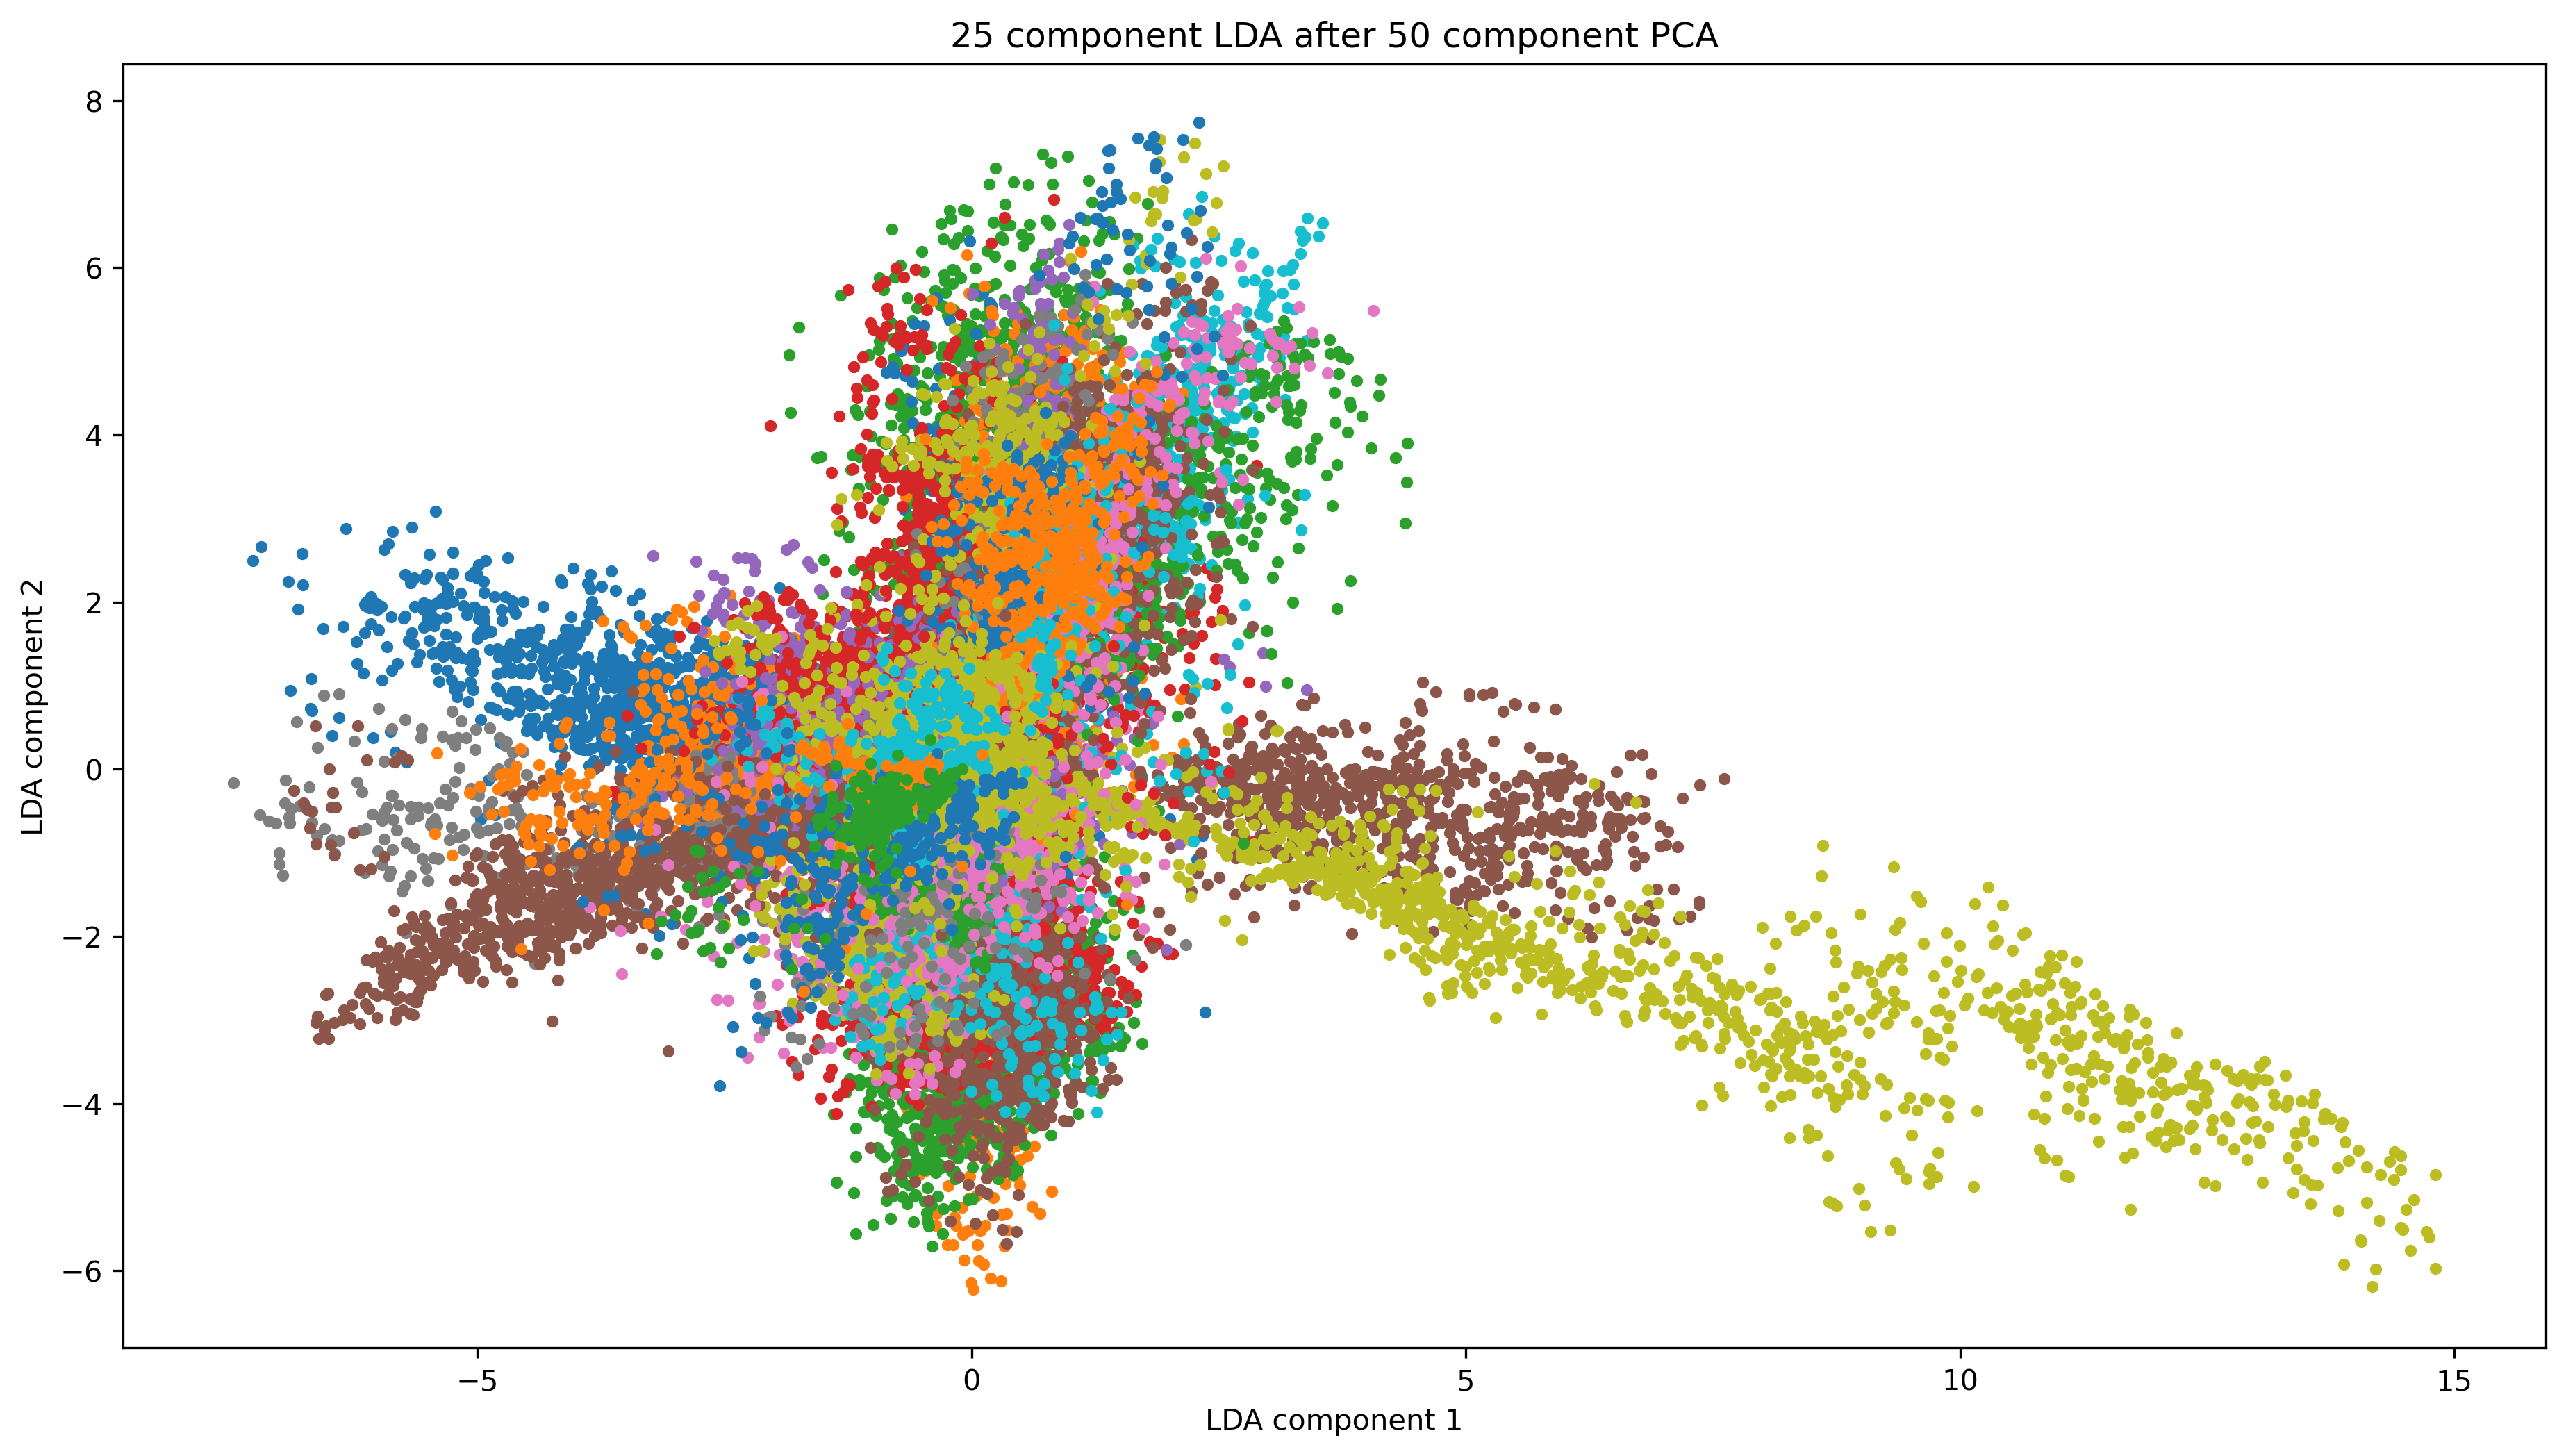

In [11]:
n_components_lda = 25
lda = LDA(n_components=n_components_lda)
lda.fit(X_train_pca, y_train)
X_train_lda = lda.transform(X_train_pca)
X_test_lda = lda.transform(X_test_pca)

classify(X_train_lda, y_train, X_test_lda, y_test)      # Run classifier

plt.figure(figsize=(15,8), dpi=300)
for classid in train_data["ClassId"].unique():
    idx = np.where(train_data["ClassId"] == classid)
    plt.scatter(X_train_lda[idx,0], X_train_lda[idx,1], s=10)

plt.title('%d component LDA after %d component PCA' %(n_components_lda, n_components_pca))
plt.xlabel('LDA component 1')
plt.ylabel('LDA component 2')
plt.show()

We observe that after implementing LDA with just 25 components, we see a marginal increase in the test accuracy score. Thus LDA maintains/enhances performance compared to PCA alone, while having less no. of features (half in this case).

We also observe that the first 2 components of LDA seperates (maintains the variance of) the classes a lot more compared to that of PCA (figures above). The classes are more spread out/seperated after LDA, compared to only PCA. Thus LDA should be implemented to obtain a better classifier. This might be due to the fact that PCA is unsupervised, and does not use class information of the training dataset. However, LDA is a supervised algorithm which takes into account the class information as well.

## PCA (25 components)

Directly reducing to 25 features without LDA

In [12]:
n_components_pca = 25
pca = PCA(n_components=n_components_pca)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("PCA applied training data shape: ", X_train_pca.shape)
print("Variance explained by %d components = %0.1f%%" %(n_components_pca, sum(pca.explained_variance_ratio_*100)))
print("Variance explained by #1 component = %0.1f%%" %(pca.explained_variance_ratio_[0] * 100))
print("Variance explained by #1 + #2 components = %0.1f%%" %sum(pca.explained_variance_ratio_[:2]*100))

PCA applied training data shape:  (39209, 25)
Variance explained by 25 components = 88.3%
Variance explained by #1 component = 53.0%
Variance explained by #1 + #2 components = 64.4%


So a 25 component PCA explains 88% of the data variance, which is lesser than the 92% of the 50 component PCA.

In [13]:
classify(X_train_pca, y_train, X_test_pca, y_test)      # Run classifier

Correct | Incorrect classification on testing data = 73.66%, 26.34%


## Comments

| Reduction method    	| Correct 	| Incorrect 	|
|---------------------	|:-------:	|:---------:	|
| PCA (25)            	|   74%   	|    26%    	|
| PCA (50)            	|   84%   	|    16%    	|
| PCA (50) + LDA (25) 	|   85%   	|    15%    	|

The original data has 4446 dimensions (38x38x3).

We observe that if only PCA is applied, increasing dimensions significantly increases the accuracy of our classification (from 74% to 84% by doubling dimensions).
We observe that LDA applied on PCA data has the best accuracy w.r.t test data. This might be due to the supervised learning nature of LDA. Even though the accuracy improves marginally in this example, classification is achieved with only 25 features in the case of LDA, while 50 features are required for the similar accuracy using PCA. This difference grows larger when dimensions are further reduced.

In order to improve the performance of the system, 

1. We can introduce more training data.
2. The dimensionality reduction via PCA can be done for more number of components, before further reduction via LDA. This way we pass a dataset with more variance to the LDA.

# Problem 2 (Lotka Volterra model)

Given $b=p=r=d=1 \quad x_1(0) = 0.3, x_2(0)=0.2$. We assume step size $h=0.05$ for this problem.

The Lotka-Volterra model is given by,

$$\begin{aligned} \mathbf{x}^{\prime} &=\mathbf{f}(\mathbf{x}) \\ \mathbf{x} &=\left(\begin{array}{l}x_1 \\ x_2\end{array}\right)=\left(\begin{array}{c}\text { Prey population } \\ \text { Predator population }\end{array}\right) \\ \mathbf{f}(\mathbf{x}) &=\left(\begin{array}{c}\left(b-p x_2\right) x_1 \\ \left(r x_1-d\right) x_2\end{array}\right)\end{aligned}$$

We will use **two simultaneous RK4** solvers to solve this problem.

$$\begin{aligned} 
\left[\begin{array}{c} k_1 \\ l_1 \end{array}\right] &=h \cdot \mathbf{f}\left(x_{1,n}, x_{2,n}\right) \\ \\
\left[\begin{array}{c} k_2 \\ l_2 \end{array}\right] &=h \cdot \mathbf{f}\left(x_{1,n} + 0.5k_1, x_{2,n} + 0.5l_1\right) \\ \\
\left[\begin{array}{c} k_3 \\ l_3 \end{array}\right] &=h \cdot \mathbf{f}\left(x_{1,n} + 0.5k_2, x_{2,n} + 0.5l_2\right) \\ \\
\left[\begin{array}{c} k_4 \\ l_4 \end{array}\right] &=h \cdot \mathbf{f}\left(x_{1,n} + k_3, x_{2,n} + l_3\right)
\end{aligned}$$

$$\boxed{\begin{aligned}
x_{1,n+1} &=x_{1,n}+\frac{1}{6} k_1+\frac{1}{3} k_2+\frac{1}{3} k_3+\frac{1}{6} k_4+O\left(h^5\right) \\
x_{2,n+1} &=x_{2,n}+\frac{1}{6} l_1+\frac{1}{3} l_2+\frac{1}{3} l_3+\frac{1}{6} l_4+O\left(h^5\right)
\end{aligned}}$$


Where we ignore the $O\left(h^5\right)$ terms.

In [14]:
def f(x1, x2, b=1, p=1, r=1, d=1):
    """
    Return derivative vector.
    """
    return np.array([(b - p*x2)*x1, (r*x1 - d)*x2])

def RK4Solution(x,h, x1_i, x2_i):
    """
    Return solution of the ODE for the given input array by RK 4th order method. Given y(1) = -1.
    """
    N = x.shape[0]
    x1 = np.zeros(N)                    # Prey population 
    x2 = np.zeros(N)                    # Predator population
    x1[0], x2[0] = x1_i, x2_i             # Given initial condition

    for i in range(N-1):
        k1, l1 = h * f(x1[i], x2[i])
        k2, l2 = h * f(x1[i]+ 0.5*k1, x2[i]+ 0.5*l1)
        k3, l3 = h * f(x1[i]+ 0.5*k2, x2[i]+ 0.5*l2)
        k4, l4 = h * f(x1[i]+     k3, x2[i]+     l3)
        x1[i+1] = x1[i] + k1/6 + k2/3 + k3/3 + k4/6
        x2[i+1] = x2[i] + l1/6 + l2/3 + l3/3 + l4/6
    
    return x1, x2

def plotSolution(x_vals, x1, x2, x_init_prey, x_init_predator):
    plt.figure(figsize=(20, 6), dpi=300)
    plt.plot(x_vals, x1, label='Prey population')
    plt.plot(x_vals, x2, label='Predator population')
    plt.title('Initial populations (prey = %0.1f, predator = %0.1f)' %(x_init_prey, x_init_predator))
    plt.xlabel('x')
    plt.ylabel('Population')
    plt.legend()
    plt.show()

In [15]:
h = 0.05    # Step size
x_vals = np.arange(0,20,h)

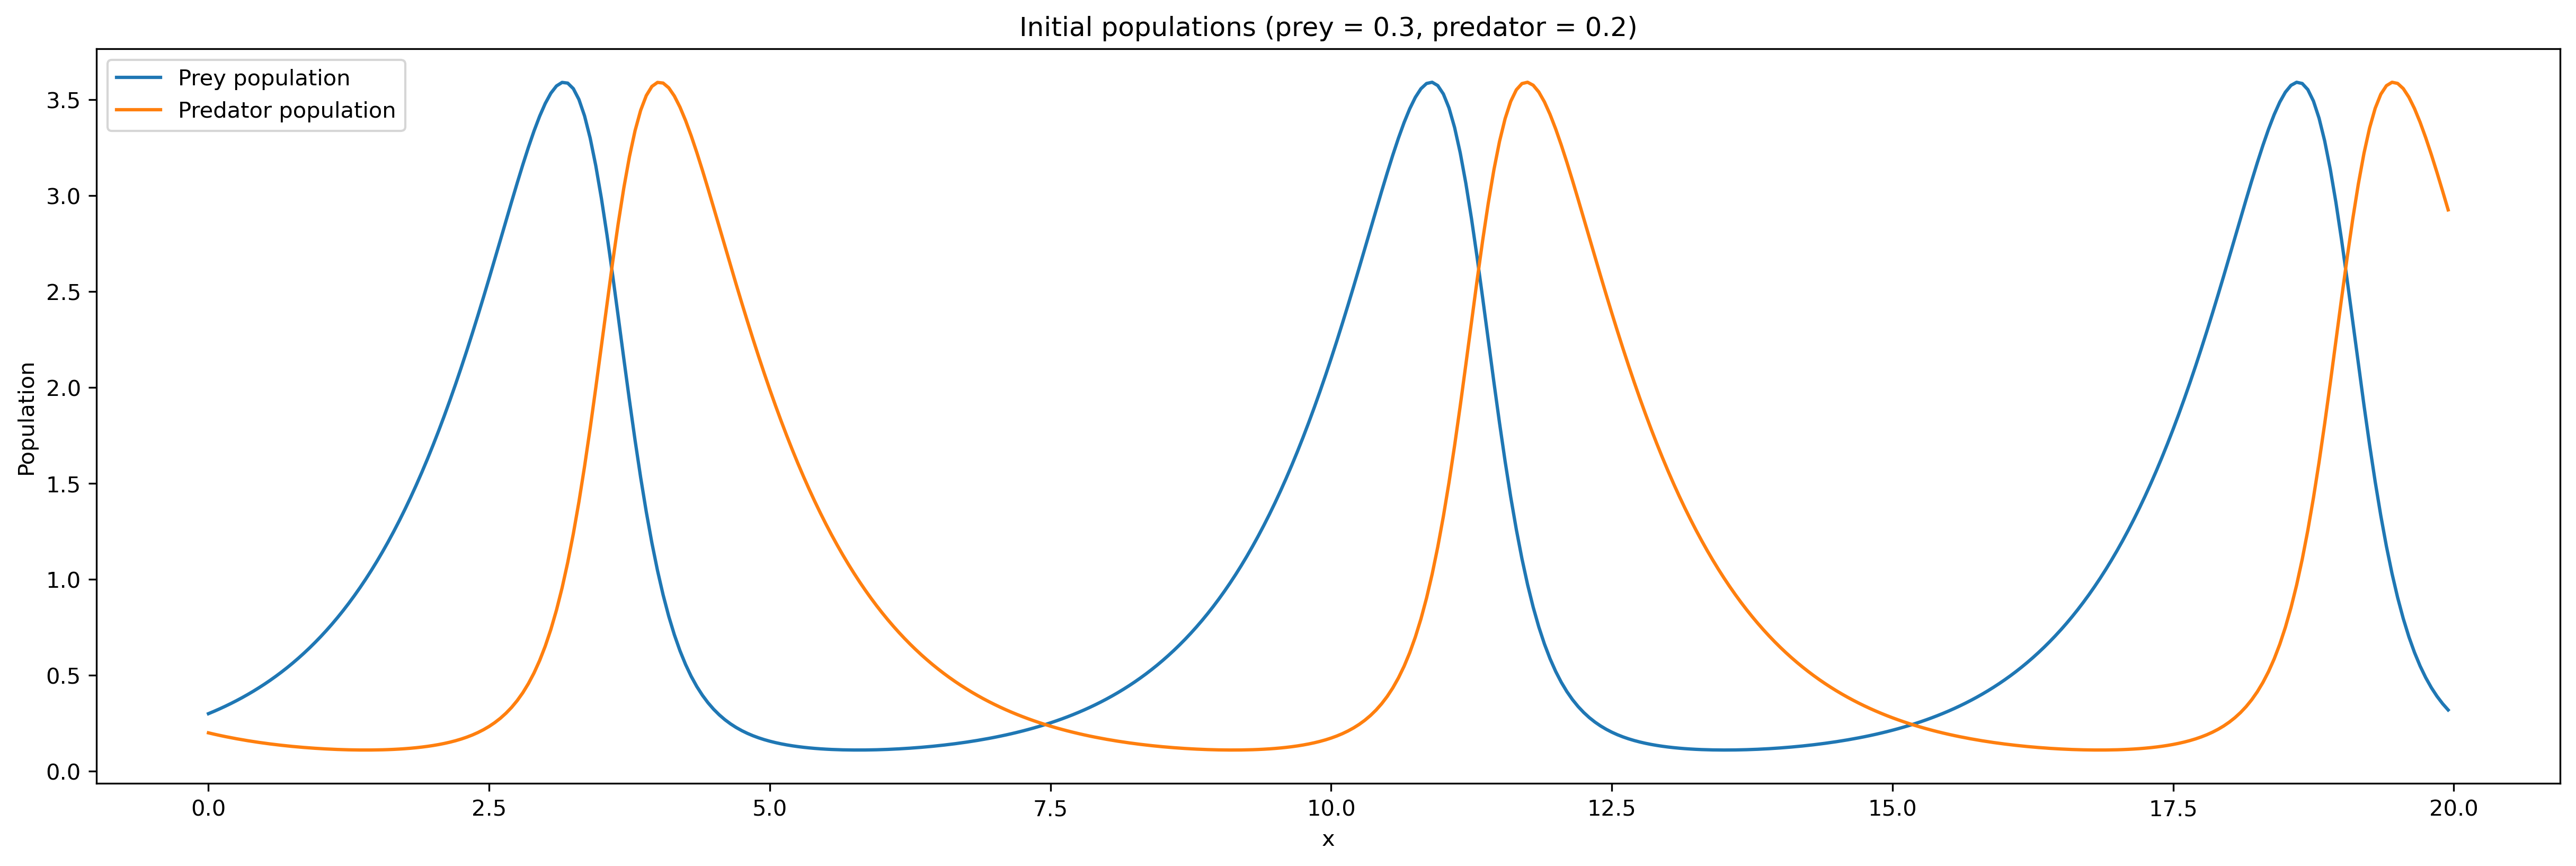

In [16]:
# x_init_prey, x_init_predator = 0.3, 0.2
x_init_prey, x_init_predator = 0.3, 0.2
x1, x2 = RK4Solution(x_vals, h, x_init_prey, x_init_predator)
plotSolution(x_vals, x1, x2, x_init_prey, x_init_predator)

**Comments**

- We see that initially when the predator population is low, the prey population flourishes. The predator population continues to decrease, until there is enough prey population, after which the predator population also increases. 
- The prey population continues to increase, however the predator population also increases due to more food available. 
- The prey population reaches a peak value, beyond which it starts decreasing due to the increasing predators. The predator population peaks sometime later.   
- Less food available for the predators means that predator population now decreases.
- Decreasing predators means that prey population now flourishes. 

This cyclic behaviour is repeated for all time.

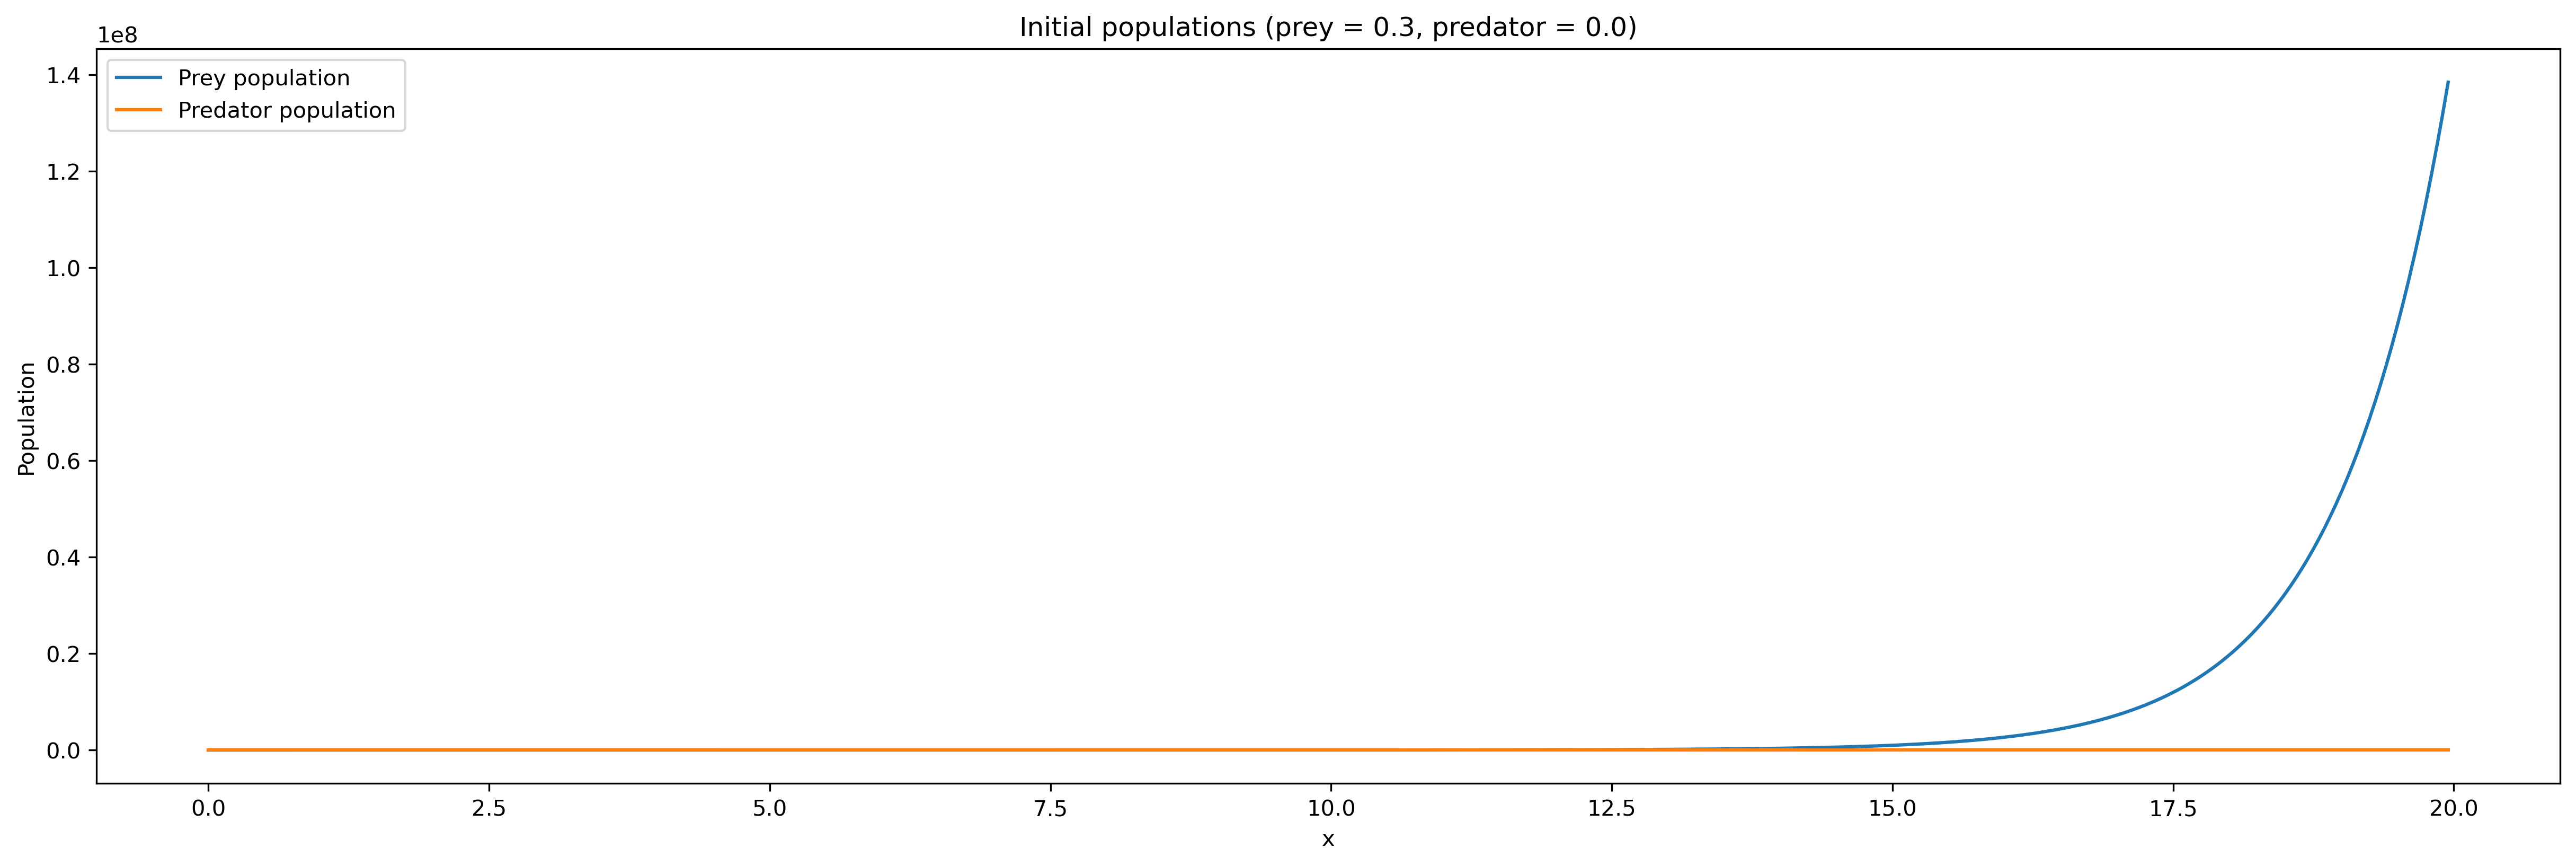

In [17]:
# No predator
# x_init_prey, x_init_predator = 0.3, 0
x_init_prey, x_init_predator = 0.3, 0
x1, x2 = RK4Solution(x_vals, h, x_init_prey, x_init_predator)
plotSolution(x_vals, x1, x2, x_init_prey, x_init_predator)

When no predators are present, we can see that prey population increases exponentially.

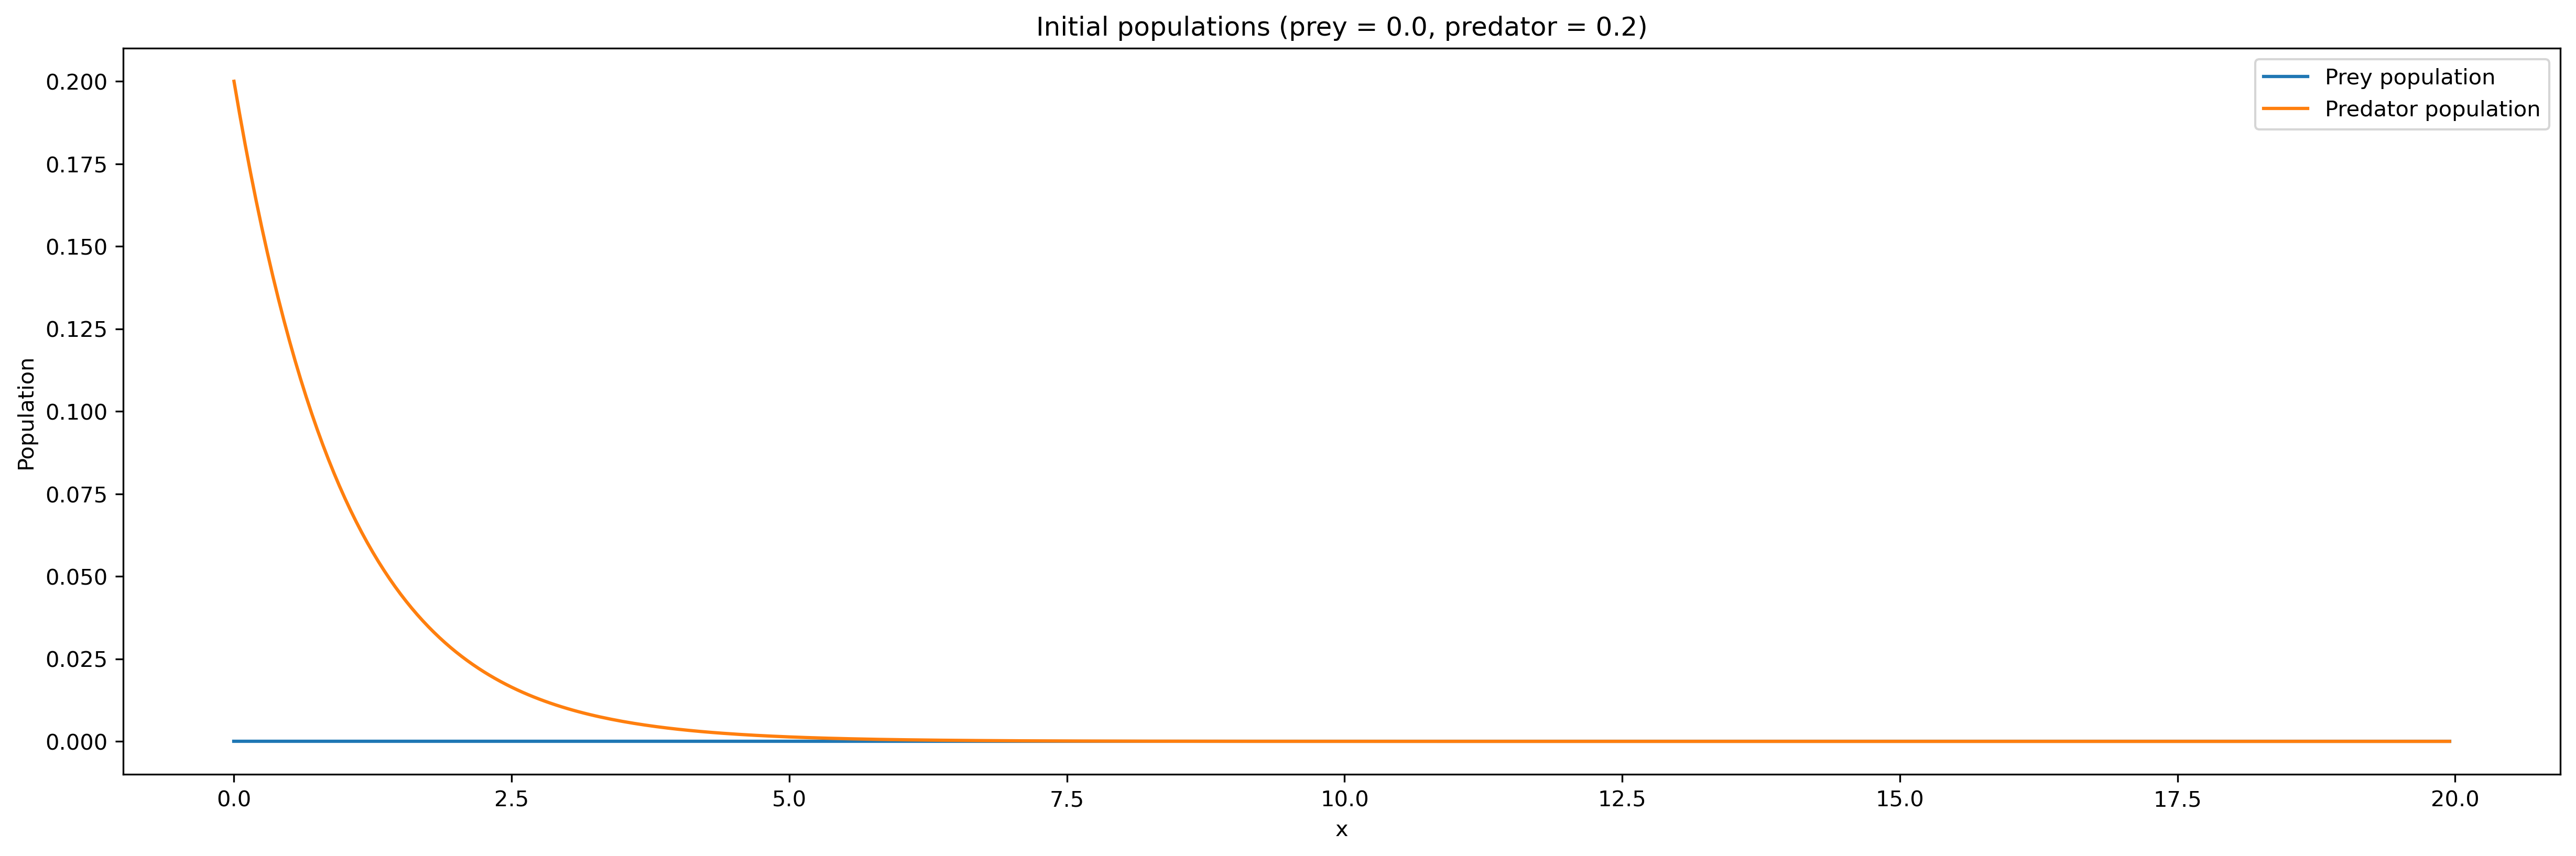

In [18]:
# No preys
# x_init_prey, x_init_predator = 0, 0.2
x_init_prey, x_init_predator = 0, 0.2
x1, x2 = RK4Solution(x_vals, h, x_init_prey, x_init_predator)
plotSolution(x_vals, x1, x2, x_init_prey, x_init_predator)

When no preys are present, we see that predator population decreases exponentially to zero.